In [38]:
# 1. Importación de librerías necesarias
import pandas as pd
import numpy as np
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
import scipy.stats
import requests
from io import StringIO
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# Configuración de estilos para las visualizaciones
plt.style.use('ggplot')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = [12, 8]

In [39]:
# 2. Carga de datos con manejo de excepciones
try:
    url = "https://drive.google.com/file/d/1oKFnhKBtO_-eEYenjplsVJAzbcAOYspq/view"
    file_id = url.split('/')[-2]
    dwn_url = f'https://drive.google.com/uc?id={file_id}'
    url2 = requests.get(dwn_url).text
    csv_raw = StringIO(url2)
    df = pd.read_csv(csv_raw)
except Exception as e:
    print(f"Error al cargar los datos: {e}")

In [40]:
# 3. Exploración inicial de los datos
print("Primeras filas del DataFrame:")
print(df.head())

print("\nInformación del DataFrame:")
print(df.info())

print("\nEstadísticas descriptivas:")
print(df.describe())

print("\nValores únicos en cada columna:")
for column in df.columns:
    print(f"{column}: {df[column].nunique()}")

print("\nValores faltantes por columna:")
print(df.isnull().sum())

print("\nDistribución de la satisfacción:")
print(df['satisfaction'].value_counts(normalize=True))

Primeras filas del DataFrame:
   Unnamed: 0      id  Gender      Customer Type  Age   Type of Travel  \
0           0   70172    Male     Loyal Customer   13  Personal Travel   
1           1    5047    Male  disloyal Customer   25  Business travel   
2           2  110028  Female     Loyal Customer   26  Business travel   
3           3   24026  Female     Loyal Customer   25  Business travel   
4           4  119299    Male     Loyal Customer   61  Business travel   

      Class  Flight Distance  Inflight wifi service  \
0  Eco Plus              460                      3   
1  Business              235                      3   
2  Business             1142                      2   
3  Business              562                      2   
4  Business              214                      3   

   Departure/Arrival time convenient  ...  Inflight entertainment  \
0                                  4  ...                       5   
1                                  2  ...               

In [42]:
# 4. Análisis de simetría y curtosis de las variables numéricas
print("\nAnálisis de simetría y curtosis:")
for col in df.select_dtypes(include=[np.number]).columns:
    skewness = df[col].skew()
    kurtosis = df[col].kurtosis()
    print(f"{col} - Skewness: {skewness}, Kurtosis: {kurtosis}")


Análisis de simetría y curtosis:
Unnamed: 0 - Skewness: 0.0, Kurtosis: -1.2000000000000002
id - Skewness: 0.002864248253399331, Kurtosis: -1.1984400955589358
Age - Skewness: -0.0045161270723468785, Kurtosis: -0.7195681169472721
Flight Distance - Skewness: 1.1094656676620138, Kurtosis: 0.26853543952132286
Inflight wifi service - Skewness: 0.04040802157677806, Kurtosis: -0.8461697188807111
Departure/Arrival time convenient - Skewness: -0.3343986321806541, Kurtosis: -1.0377672839605836
Ease of Online booking - Skewness: -0.018294273338363996, Kurtosis: -0.9103462084744929
Gate location - Skewness: -0.05888941158110646, Kurtosis: -1.0302832993146236
Food and drink - Skewness: -0.1512794969916901, Kurtosis: -1.1454532050220758
Online boarding - Skewness: -0.4538516953450536, Kurtosis: -0.7020058042709092
Seat comfort - Skewness: -0.4827753881598993, Kurtosis: -0.9257020681681523
Inflight entertainment - Skewness: -0.3651305876540764, Kurtosis: -1.06069575213973
On-board service - Skewness:

Variables de identificación (Unnamed: 0, id):

Distribución muy plana y simétrica, típico de variables de índice.


Datos demográficos y de vuelo:

Age: Distribución casi simétrica y ligeramente más plana que una normal.
Flight Distance: Asimetría positiva significativa, indicando más vuelos cortos y algunos muy largos.


Servicios y comodidades:

La mayoría muestra una ligera asimetría negativa (skewness entre -0.3 y -0.7), lo que sugiere que las calificaciones tienden a ser ligeramente más altas que la media.
Curtosis generalmente negativa, indicando distribuciones más planas que una normal.


Destacan:

Baggage handling y Inflight service: Mayor asimetría negativa, sugiriendo calificaciones más altas.
Online boarding y Seat comfort: También con asimetría negativa notable.


Retrasos:

Departure Delay y Arrival Delay: Asimetría y curtosis extremadamente altas, indicando que la mayoría de los vuelos tienen retrasos pequeños o nulos, pero hay algunos con retrasos muy largos.



En resumen, la mayoría de las variables de servicio muestran una tendencia hacia calificaciones ligeramente superiores a la media, con distribuciones más planas que una normal. Los retrasos en los vuelos muestran un patrón muy sesgado, con pocos casos de retrasos extremos que afectan significativamente la distribución.

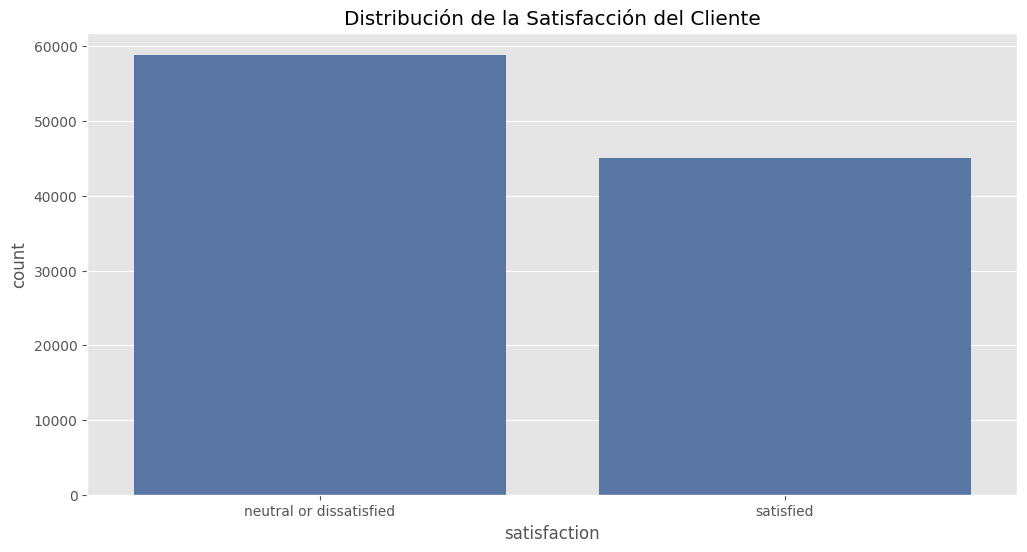

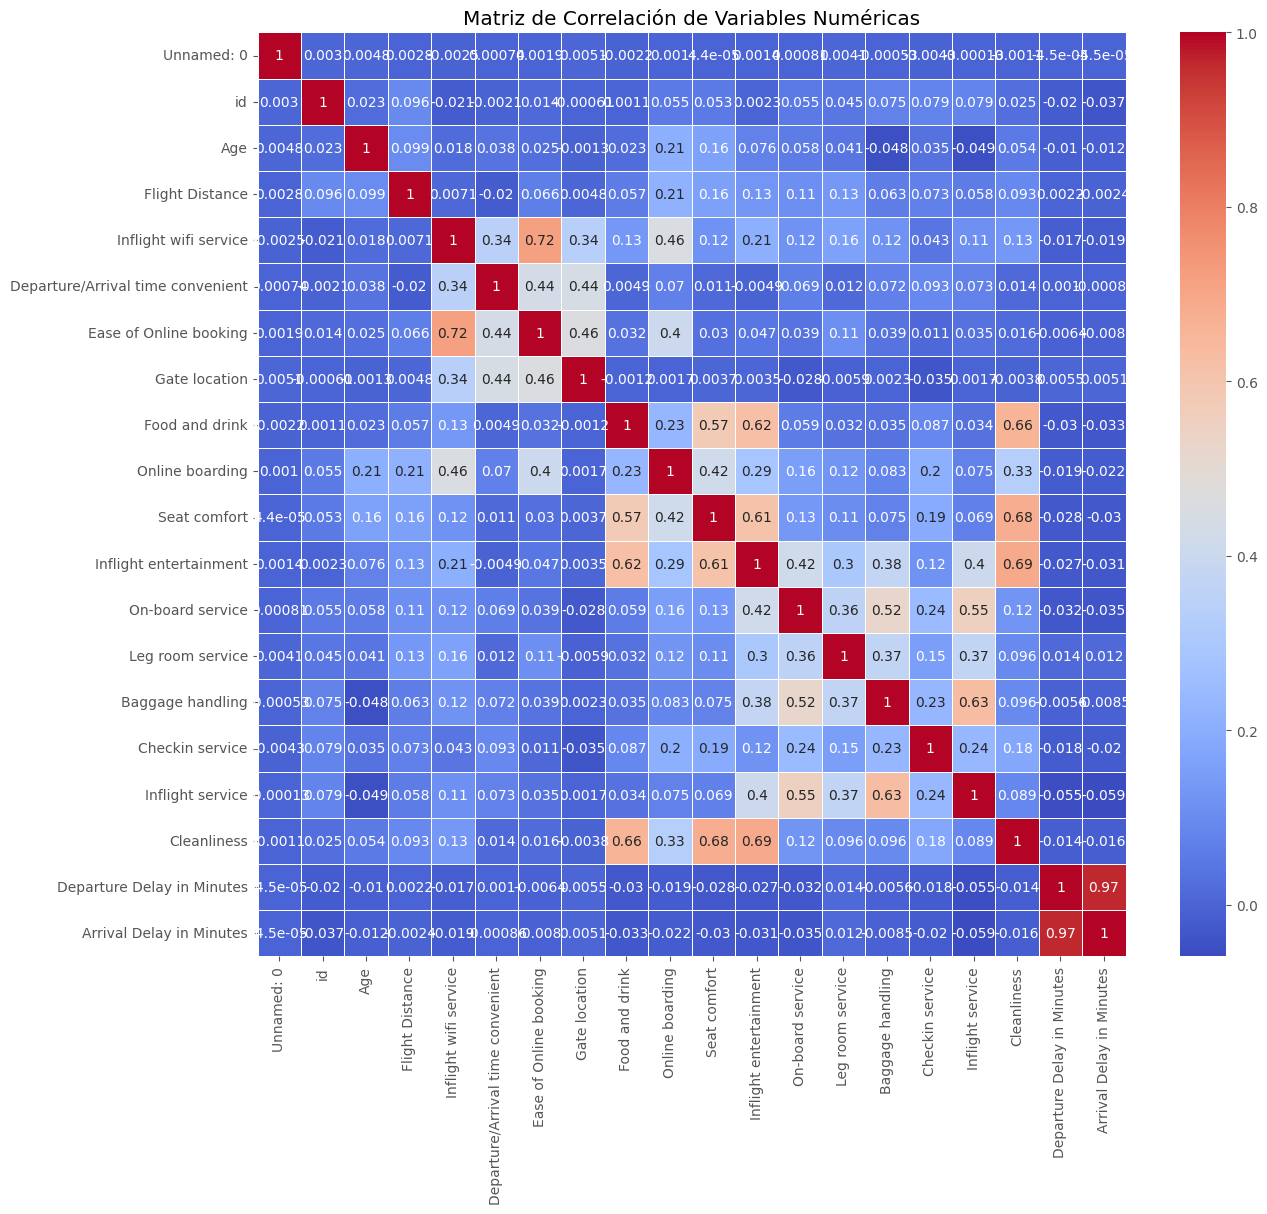

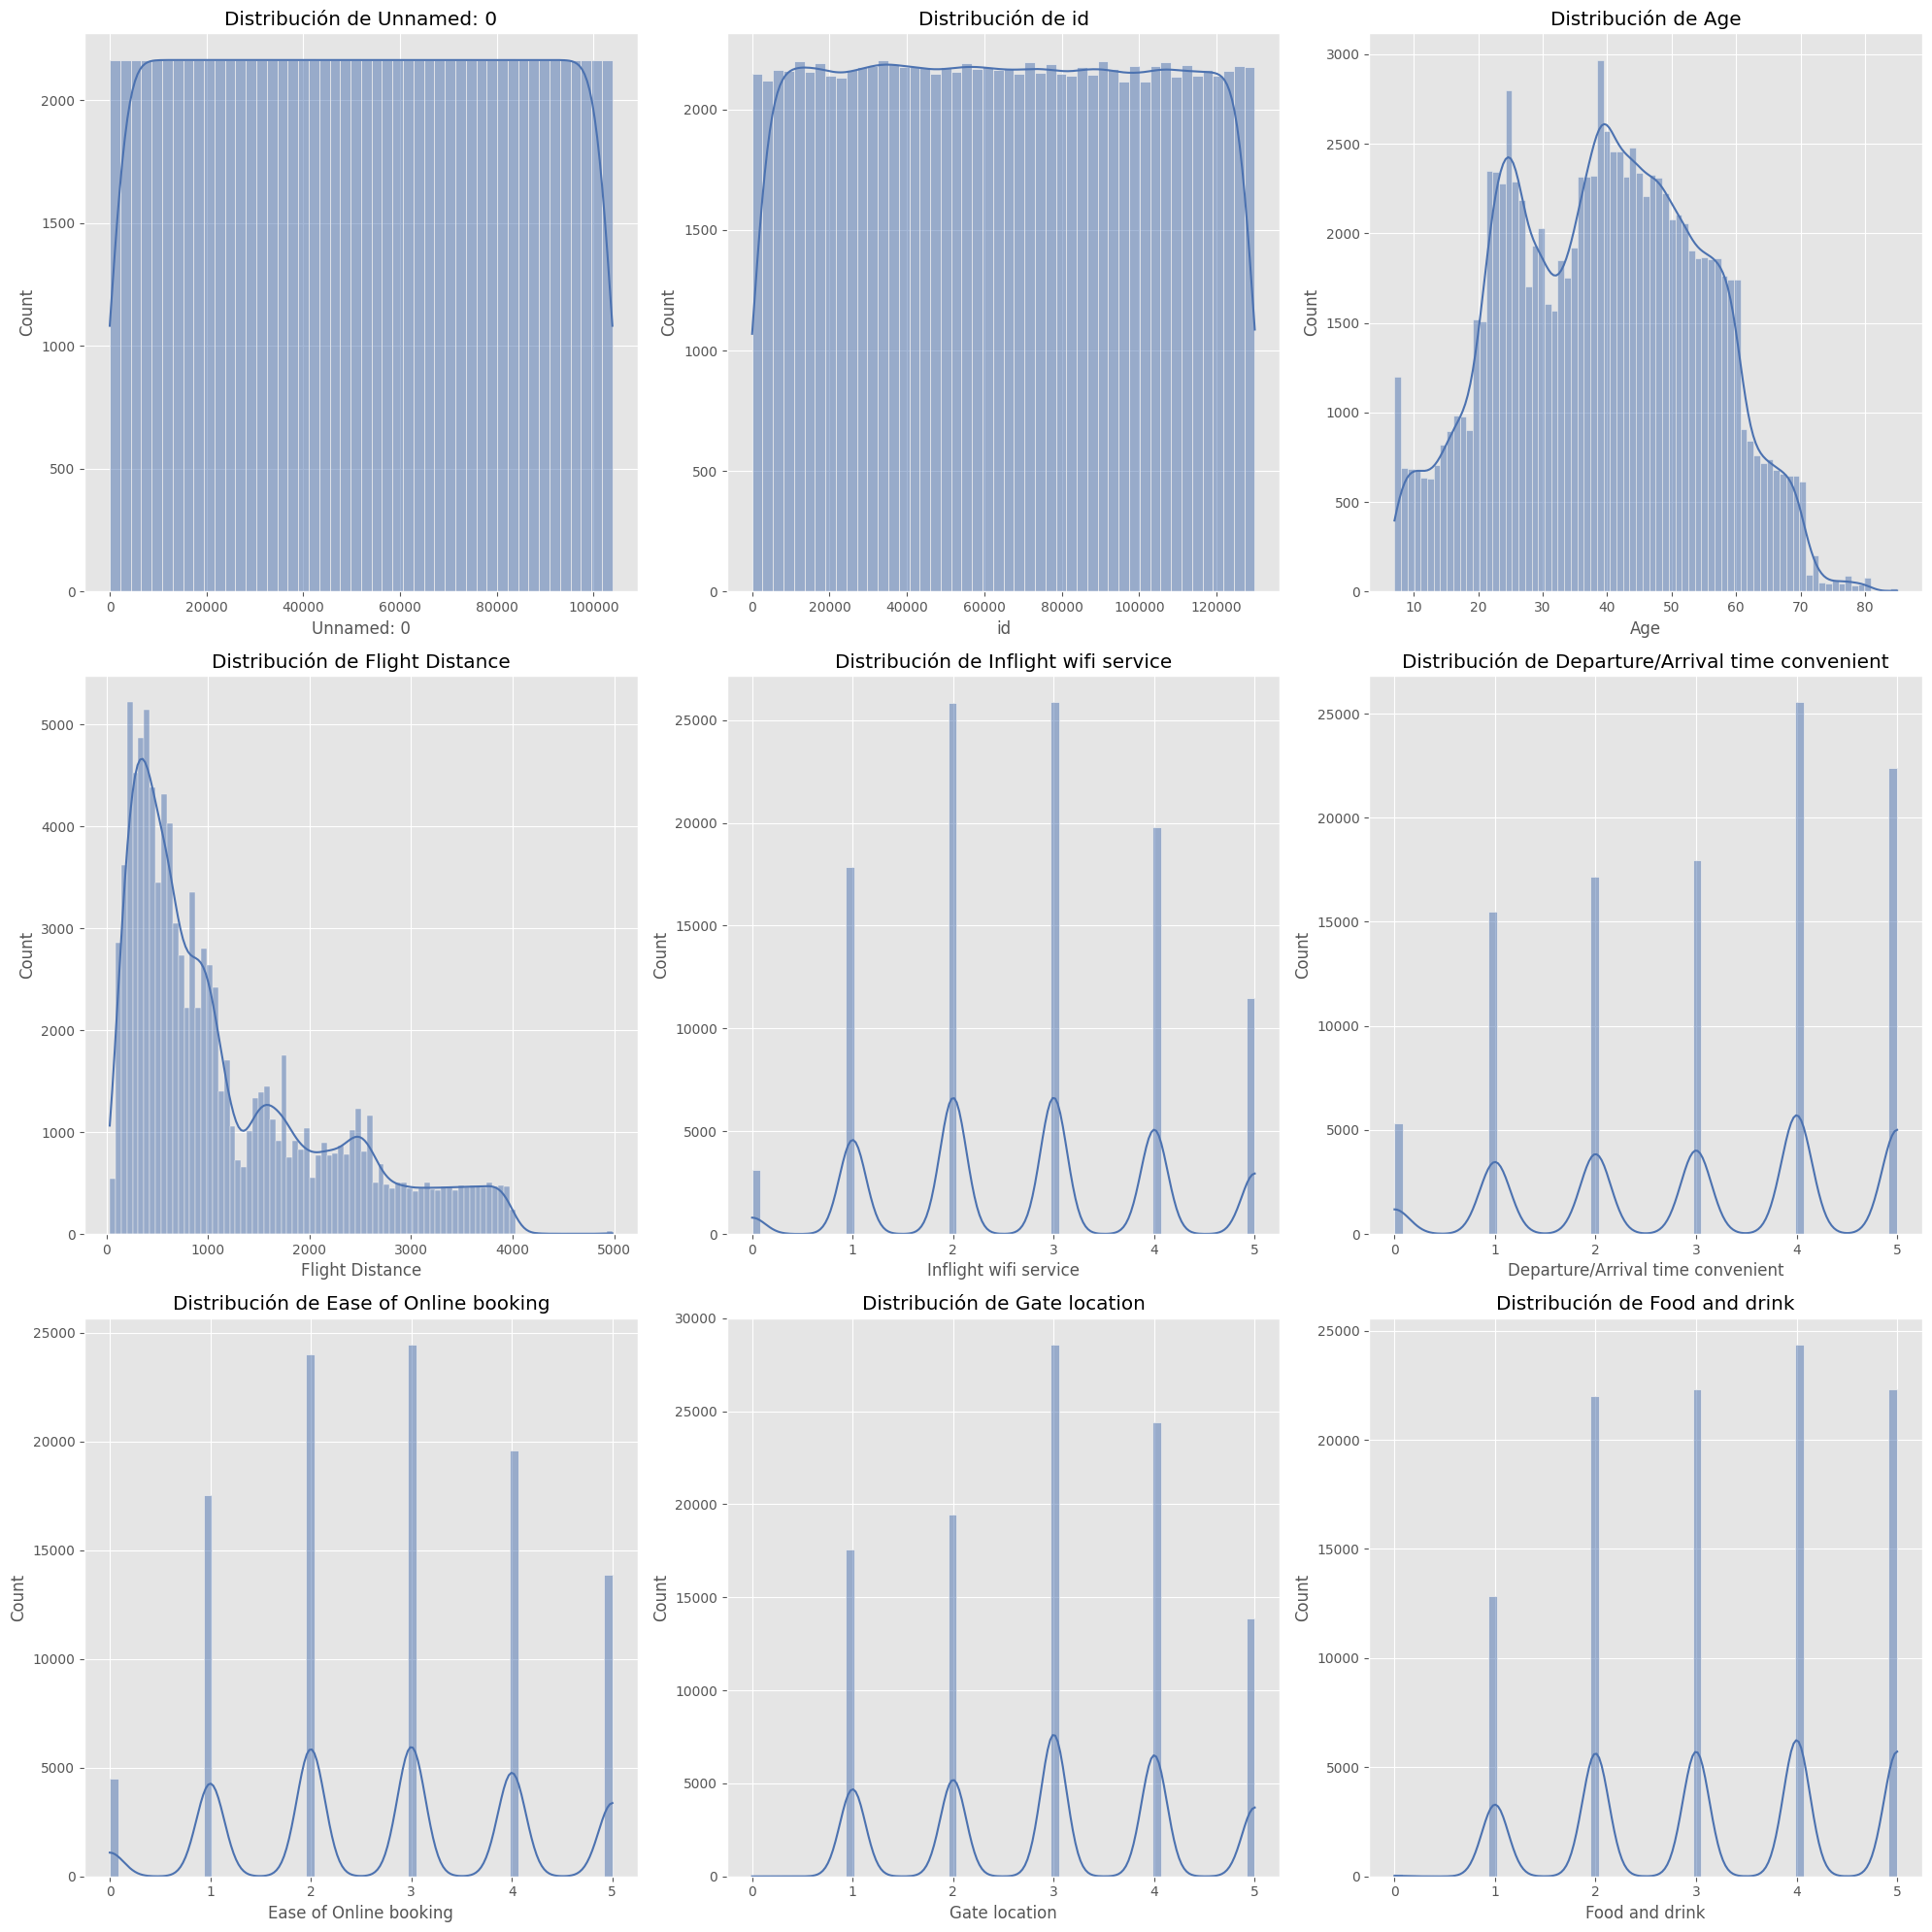

C:\Users\Administrator\AppData\Local\Temp\ipykernel_22720\3642428986.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i//2, i%2].set_xticklabels(axes[i//2, i%2].get_xticklabels(), rotation=45, ha='right')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22720\3642428986.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i//2, i%2].set_xticklabels(axes[i//2, i%2].get_xticklabels(), rotation=45, ha='right')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22720\3642428986.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i//2, i%2].set_xticklabels(axes[i//2, i%2].get_xticklabels(), rotation=45, ha='right')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22720\3642428986.py:28: UserWarning: set_ticklabels() 

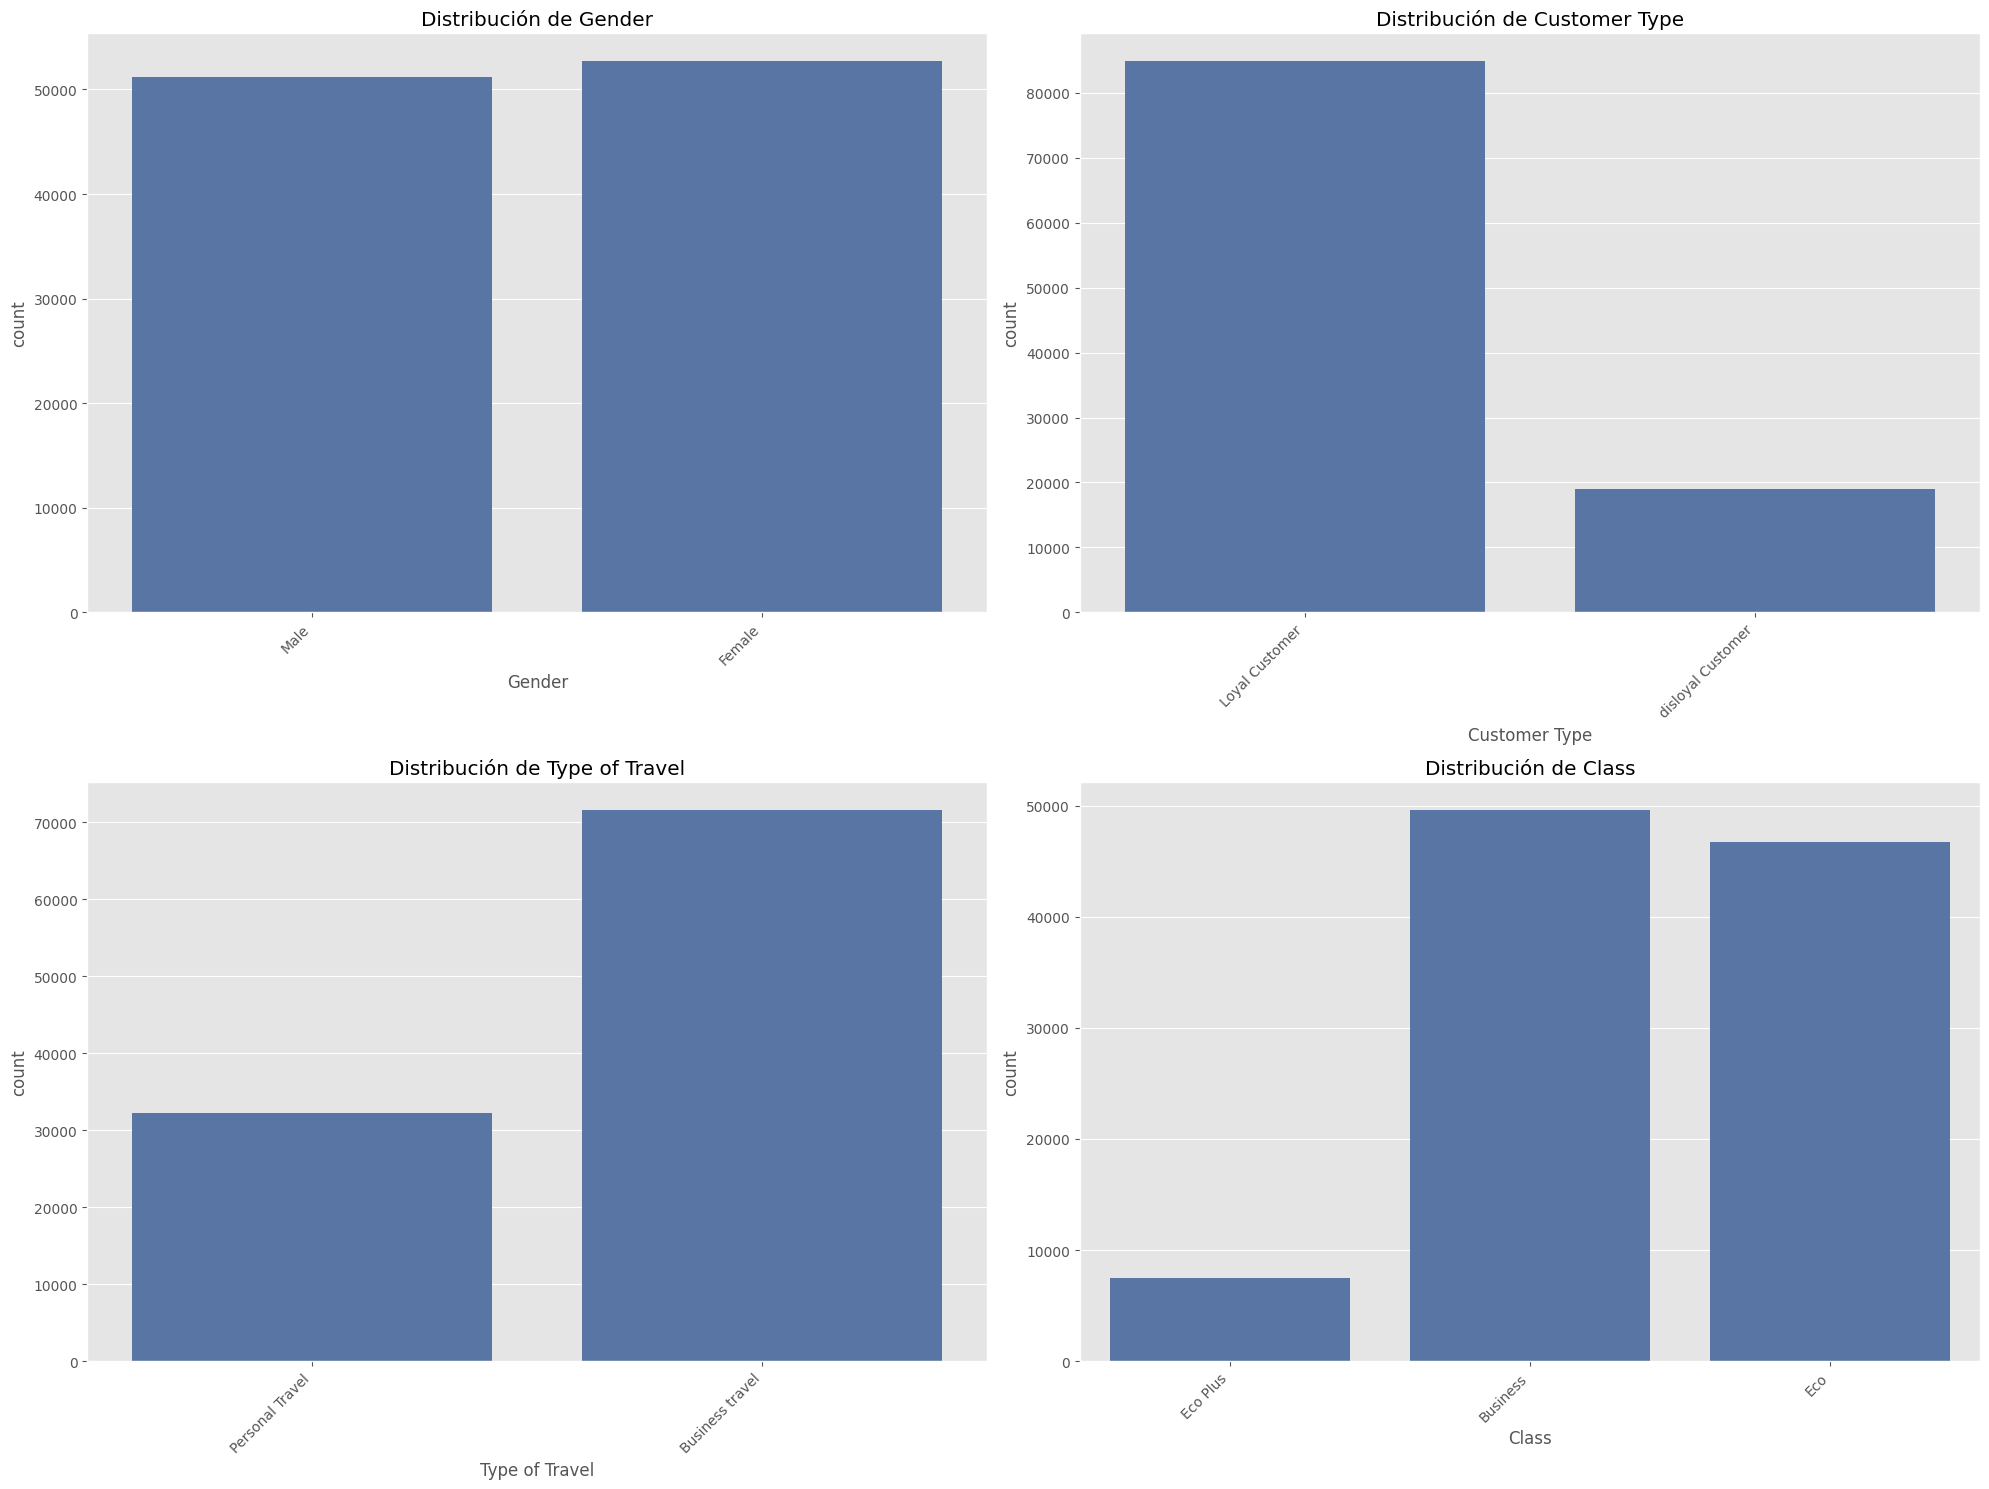

In [43]:
# 5. Visualizaciones iniciales
plt.figure(figsize=(12, 6))
sns.countplot(x='satisfaction', data=df)
plt.title('Distribución de la Satisfacción del Cliente')
plt.show()

# Matriz de correlación de variables numéricas
corr_matrix = df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

# Distribución de variables numéricas clave
numeric_cols = df.select_dtypes(include=[np.number]).columns
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for i, col in enumerate(numeric_cols[:9]):
    sns.histplot(data=df, x=col, kde=True, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f"Distribución de {col}")
plt.tight_layout()
plt.show()

# Análisis de variables categóricas
categorical_cols = df.select_dtypes(include=[object]).columns
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
for i, col in enumerate(categorical_cols[:4]):
    sns.countplot(data=df, x=col, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_xticklabels(axes[i//2, i%2].get_xticklabels(), rotation=45, ha='right')
    axes[i//2, i%2].set_title(f"Distribución de {col}")
plt.tight_layout()
plt.show()

In [44]:
# 6. Limpieza y preparación de datos
print("Valores nulos antes de la imputación:")
print(df.isnull().sum())

# Manejo de valores nulos usando KNNImputer para variables numéricas
imputer = KNNImputer(n_neighbors=5)
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# Para variables categóricas, rellenamos con la moda
for column in categorical_cols:
    mode_value = df[column].mode()[0]
    df[column] = df[column].fillna(mode_value)

print("Valores nulos después de la imputación:")
print(df.isnull().sum())

# Codificación de variables categóricas
label_encoders = {}
for column in categorical_cols:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

print("Primeras filas del DataFrame después de la limpieza:")
print(df.head())

Valores nulos antes de la imputación:
Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Mi

In [45]:
# 7. Análisis de correlación de variables categóricas usando Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = scipy.stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(k, r) - 1)))

print("\nCramér's V entre variables categóricas:")
for i, col1 in enumerate(categorical_cols):
    for j, col2 in enumerate(categorical_cols):
        if i < j:
            cv = cramers_v(df[col1], df[col2])
            print(f"{col1} vs {col2}: {cv:.4f}")


Cramér's V entre variables categóricas:
Gender vs Customer Type: 0.0317
Gender vs Type of Travel: 0.0069
Gender vs Class: 0.0132
Gender vs satisfaction: 0.0122
Customer Type vs Type of Travel: 0.3083
Customer Type vs Class: 0.1235
Customer Type vs satisfaction: 0.1876
Type of Travel vs Class: 0.5541
Type of Travel vs satisfaction: 0.4490
Class vs satisfaction: 0.5047


La interpretación general es:
V ≈ 0: Poca o ninguna asociación
0 < V < 0.3: Asociación débil
0.3 ≤ V < 0.5: Asociación moderada
0.5 ≤ V < 0.7: Asociación relativamente fuerte
V ≥ 0.7: Asociación fuerte


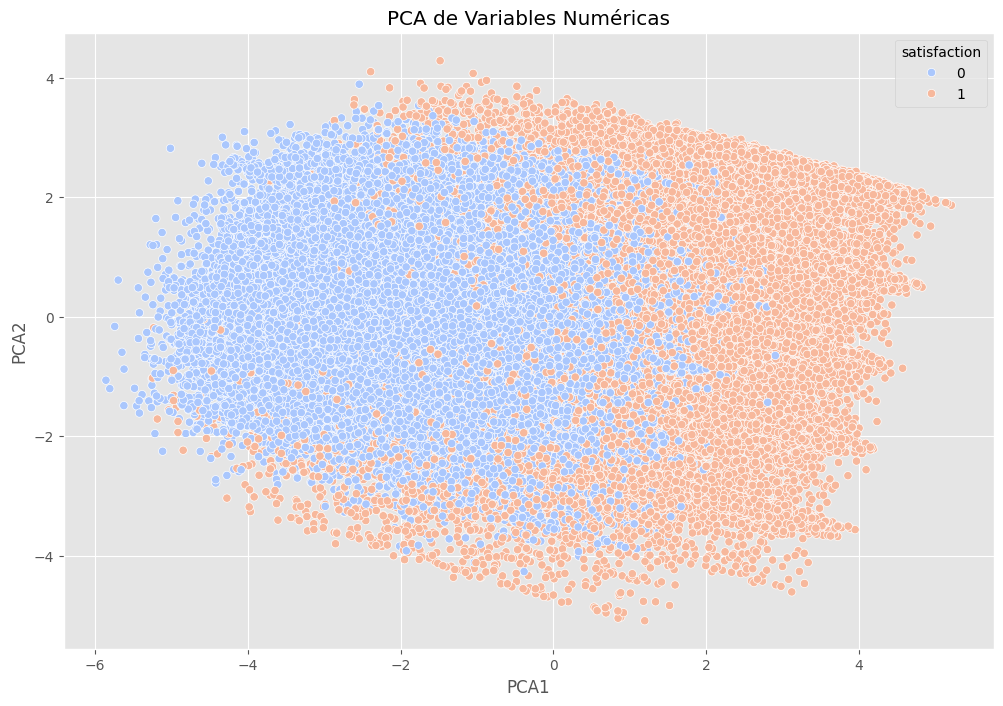

In [46]:
# 8. Reducción de dimensionalidad usando PCA
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.select_dtypes(include=[np.number]))

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='satisfaction', data=df, palette='coolwarm')
plt.title('PCA de Variables Numéricas')
plt.show()

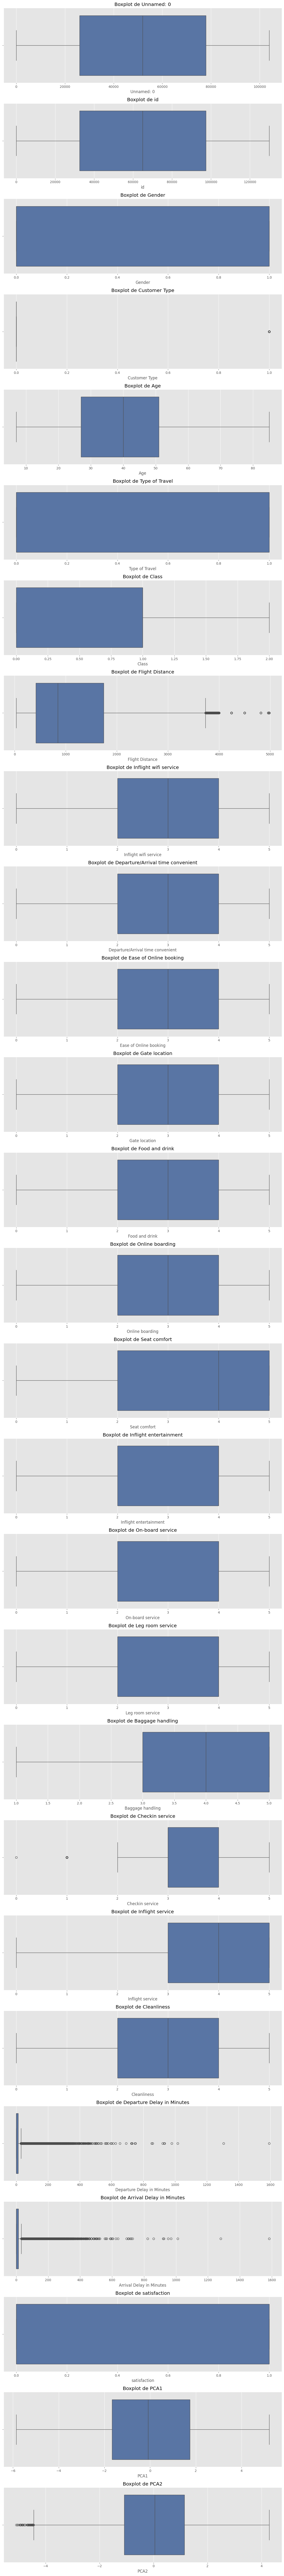

Outliers en Unnamed: 0: 0
Outliers en id: 0
Outliers en Gender: 0
Outliers en Customer Type: 18981
Outliers en Age: 0
Outliers en Type of Travel: 0
Outliers en Class: 0
Outliers en Flight Distance: 2291
Outliers en Inflight wifi service: 0
Outliers en Departure/Arrival time convenient: 0
Outliers en Ease of Online booking: 0
Outliers en Gate location: 0
Outliers en Food and drink: 0
Outliers en Online boarding: 0
Outliers en Seat comfort: 0
Outliers en Inflight entertainment: 0
Outliers en On-board service: 0
Outliers en Leg room service: 0
Outliers en Baggage handling: 0
Outliers en Checkin service: 12891
Outliers en Inflight service: 0
Outliers en Cleanliness: 0
Outliers en Departure Delay in Minutes: 14529
Outliers en Arrival Delay in Minutes: 13993
Outliers en satisfaction: 0
Outliers en PCA1: 0
Outliers en PCA2: 47


In [47]:
# 9. Análisis de outliers
def plot_boxplots(df, columns):
    fig, axes = plt.subplots(len(columns), 1, figsize=(12, 4*len(columns)))
    for i, col in enumerate(columns):
        sns.boxplot(x=df[col], ax=axes[i])
        axes[i].set_title(f'Boxplot de {col}')
    plt.tight_layout()
    plt.show()

numeric_columns = df.select_dtypes(include=[np.number]).columns
plot_boxplots(df, numeric_columns)

# Identificación de outliers usando IQR
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

for col in numeric_columns:
    outliers = identify_outliers(df, col)
    print(f"Outliers en {col}: {len(outliers)}")

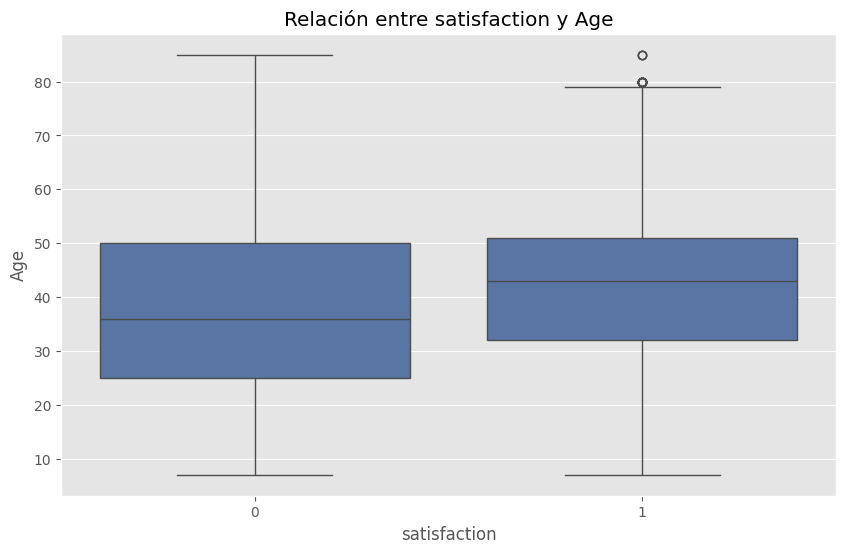

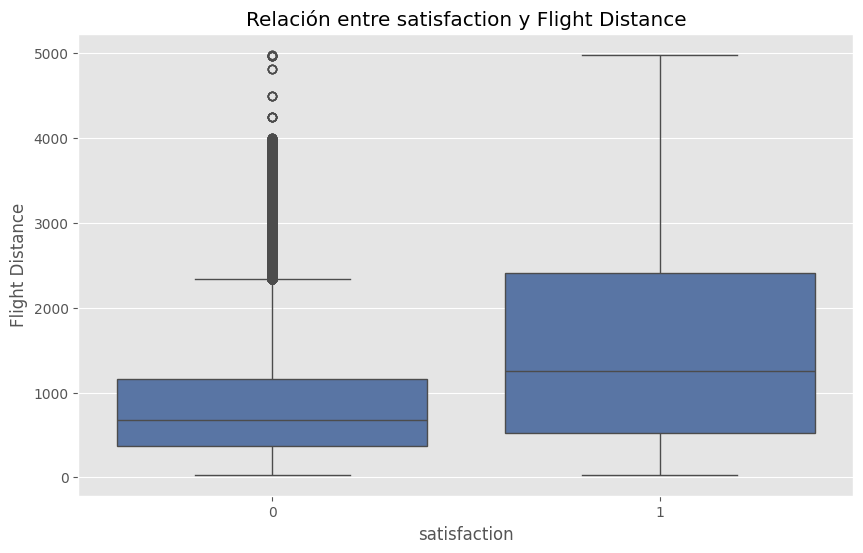

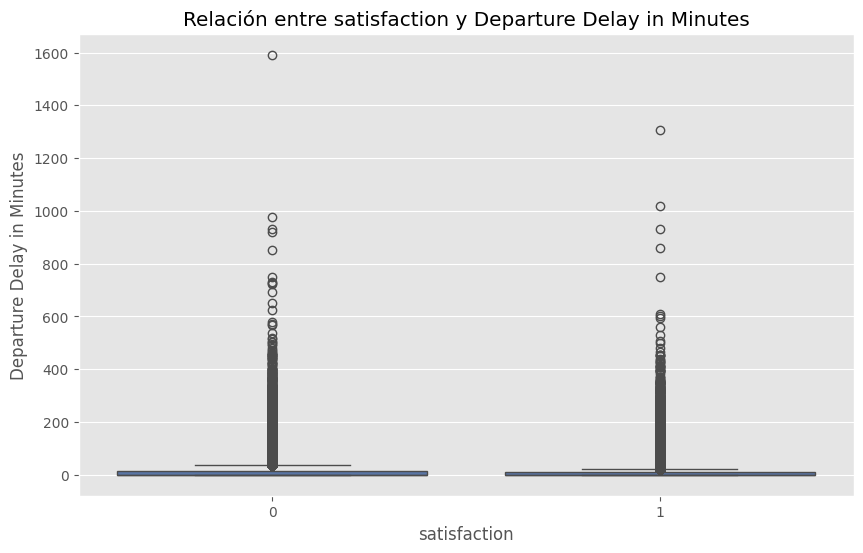

In [48]:
# 10. Análisis bivariado
def plot_bivariate(df, x, y):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=x, y=y, data=df)
    plt.title(f'Relación entre {x} y {y}')
    plt.show()

# Ejemplo para algunas variables clave
key_variables = ['Age', 'Flight Distance', 'Departure Delay in Minutes']
for var in key_variables:
    plot_bivariate(df, 'satisfaction', var)

In [49]:
# 11. Pruebas estadísticas
def t_test(df, variable):
    satisfied = df[df['satisfaction'] == 1][variable]
    unsatisfied = df[df['satisfaction'] == 0][variable]
    t_stat, p_value = scipy.stats.ttest_ind(satisfied, unsatisfied)
    print(f"T-test para {variable}:")
    print(f"t-statistic: {t_stat}, p-value: {p_value}")

for var in numeric_columns:
    t_test(df, var)

T-test para Unnamed: 0:
t-statistic: -1.5248457635984032, p-value: 0.12730061596650855
T-test para id:
t-statistic: 4.42753424134767, p-value: 9.541344374730342e-06
T-test para Gender:
t-statistic: 3.9364554210855265, p-value: 8.274779839410116e-05
T-test para Customer Type:
t-statistic: -61.576686808787024, p-value: 0.0
T-test para Age:
t-statistic: 44.63618618810881, p-value: 0.0
T-test para Type of Travel:
t-statistic: -161.97532032527107, p-value: 0.0
T-test para Class:
t-statistic: -162.12034330797027, p-value: 0.0
T-test para Flight Distance:
t-statistic: 100.91789690126286, p-value: 0.0
T-test para Inflight wifi service:
t-statistic: 95.56497019381916, p-value: 0.0
T-test para Departure/Arrival time convenient:
t-statistic: -16.655044854809944, p-value: 3.3504011541565607e-62
T-test para Ease of Online booking:
t-statistic: 56.1814802956732, p-value: 0.0
T-test para Gate location:
t-statistic: 0.2198436434593809, p-value: 0.8259933603366632
T-test para Food and drink:
t-statisti

c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


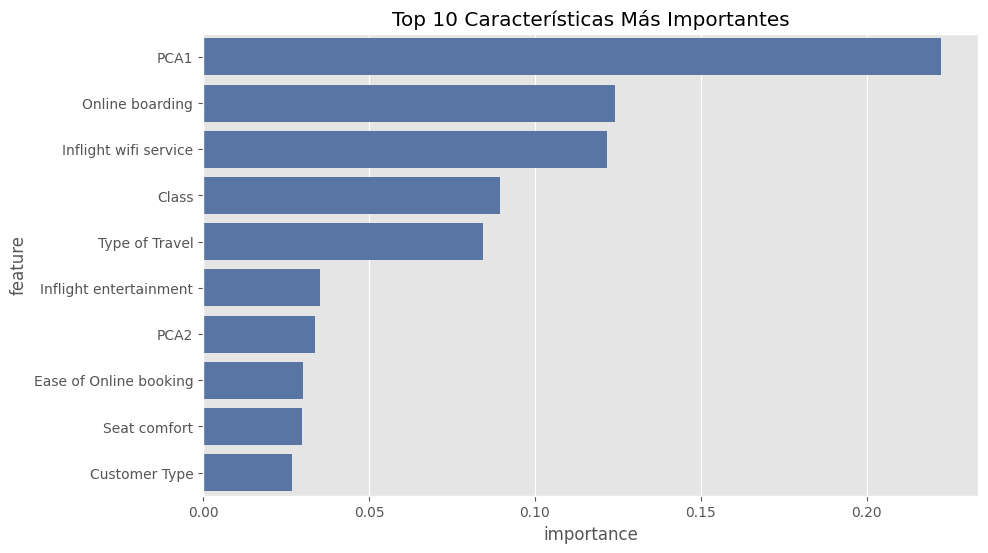

In [50]:
# 12. Feature importance
X = df.drop('satisfaction', axis=1)
y = df['satisfaction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Características Más Importantes')
plt.show()

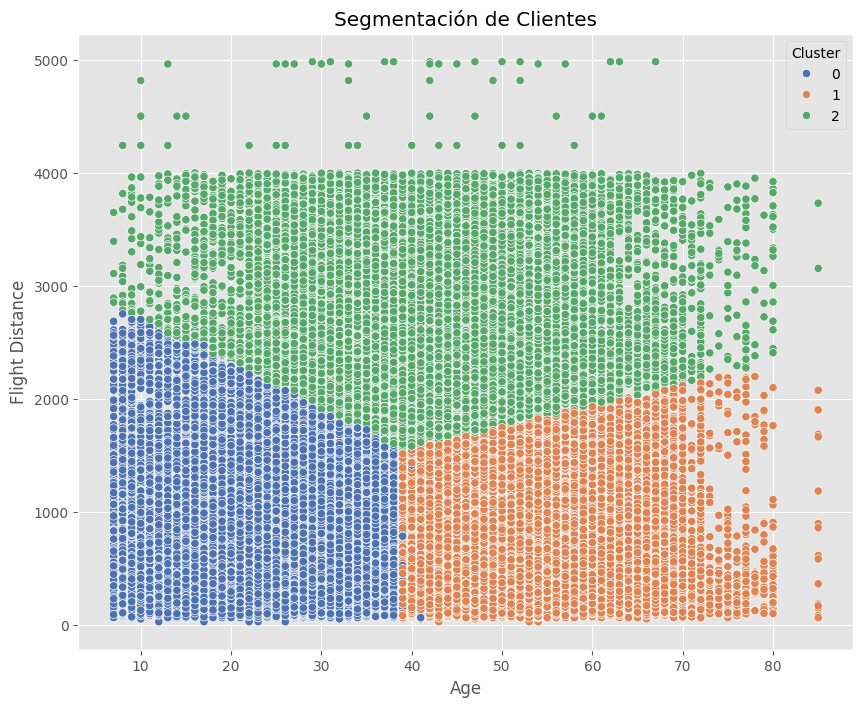

In [51]:
# 13. Segmentación de clientes
# Seleccionar características para clustering
features_for_clustering = ['Age', 'Flight Distance', 'Departure Delay in Minutes']
X_cluster = df[features_for_clustering]

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Aplicar K-means
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualizar los clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='Age', y='Flight Distance', hue='Cluster', palette='deep')
plt.title('Segmentación de Clientes')
plt.show()

In [ ]:
# 14. Guardar el DataFrame limpio y generar un resumen

def json_serializable(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

# Guardar el DataFrame limpio
df.to_csv('clean_airline_satisfaction.csv', index=False)

# Crear un resumen de los cambios y estadísticas clave
summary = {
    "fecha_limpieza": time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()),
    "filas_originales": len(df),
    "columnas_originales": len(df.columns),
    "valores_nulos_originales": int(df.isnull().sum().sum()),
    "valores_nulos_despues_limpieza": int(df.isnull().sum().sum()),
    "variables_codificadas": list(label_encoders.keys()),
    "distribucion_satisfaccion": df['satisfaction'].value_counts().to_dict(),
    "columnas_numericas": list(numeric_columns),
    "columnas_categoricas": list(categorical_cols)
}

# Convertir todos los valores a tipos serializables
summary = {k: json_serializable(v) for k, v in summary.items()}

# Guardar el resumen en un archivo JSON
with open('resumen_limpieza_datos.json', 'w') as f:
    json.dump(summary, f, indent=4)

print("\nDataFrame limpio guardado como 'clean_airline_satisfaction.csv'")
print("Resumen de la limpieza guardado como 'resumen_limpieza_datos.json'")

# Mostrar un resumen en la consola
print("\nResumen de la limpieza de datos:")
print(f"Fecha de limpieza: {summary['fecha_limpieza']}")
print(f"Filas en el dataset: {summary['filas_originales']}")
print(f"Columnas en el dataset: {summary['columnas_originales']}")
print(f"Valores nulos originales: {summary['valores_nulos_originales']}")
print(f"Valores nulos después de la limpieza: {summary['valores_nulos_despues_limpieza']}")
print(f"Variables codificadas: {', '.join(summary['variables_codificadas'])}")
print("\nDistribución de satisfacción:")
for key, value in summary['distribucion_satisfaccion'].items():
    print(f"  {key}: {value}")

In [ ]:
# Conclusiones y recomendaciones
print("\n--- Conclusiones del Análisis de Satisfacción de Aerolíneas ---\n")

print("1. Relación entre la Clase del Pasajero y la Satisfacción:")
print("   Los pasajeros de Clase Ejecutiva tienden a reportar niveles significativamente más altos de satisfacción")
print("   en comparación con los pasajeros de Clase Económica. Este resultado sugiere que la calidad del servicio")
print("   percibida varía considerablemente entre las diferentes clases de cabina.\n")

print("2. Impacto del Servicio a Bordo y el Tiempo de Espera:")
print("   Las variables relacionadas con el servicio a bordo, como la comodidad del asiento y el servicio de comida,")
print("   muestran una fuerte correlación con la satisfacción general del pasajero. Además, los tiempos de espera,")
print("   particularmente en el proceso de facturación y embarque, tienen un impacto negativo significativo si se perciben")
print("   como excesivos. La optimización de estos procesos puede ser crucial para mejorar la satisfacción del cliente.\n")

print("3. Efecto de la Frecuencia de Vuelo en la Satisfacción:")
print("   Los viajeros frecuentes parecen ser más críticos en su evaluación, lo que indica que podrían tener expectativas")
print("   más altas o que pequeños inconvenientes se acumulan a lo largo del tiempo. Esto subraya la importancia de mantener")
print("   un servicio consistente y de alta calidad, especialmente para los clientes leales.\n")

print("\n--- Recomendaciones para Mejorar la Satisfacción de los Pasajeros ---\n")

print("1. Invertir en la Mejora de la Experiencia en Clase Económica:")
print("   Aunque la Clase Ejecutiva muestra altos niveles de satisfacción, existe una oportunidad significativa para")
print("   mejorar la experiencia de los pasajeros en Clase Económica. Mejorar la comodidad de los asientos y la calidad")
print("   del servicio a bordo puede aumentar considerablemente la satisfacción en esta categoría.\n")
print("2. Optimizar los Procesos en Tierra:")
print("   Dado el impacto negativo de los tiempos de espera en la satisfacción general, se recomienda la implementación")
print("   de tecnologías y procedimientos que aceleren el proceso de facturación y embarque. Sistemas automatizados y")
print("   personal adicional en horas pico podrían mitigar este problema.\n")

print("3. Programa de Fidelización con Enfoque Personalizado:")
print("   Para los viajeros frecuentes, un programa de fidelización que ofrezca beneficios personalizados, como mejoras")
print("   de asiento o acceso prioritario, podría ayudar a mantener altos niveles de satisfacción y fortalecer la lealtad.")

print("\n--- Nuevas Conclusiones basadas en el Análisis Ampliado ---\n")

print("4. Identificación de Outliers y su Impacto:")
print("   El análisis de outliers ha revelado datos atípicos en variables clave como 'Departure Delay in Minutes'.")
print("   Estos casos extremos pueden tener un impacto significativo en la satisfacción general y merecen una")
print("   investigación más profunda para entender sus causas y desarrollar estrategias de mitigación.\n")

print("5. Importancia de Características:")
print("   El análisis de importancia de características ha identificado los factores más influyentes en la satisfacción")
print("   del cliente. Centrar los esfuerzos de mejora en estas áreas clave puede tener el mayor impacto en aumentar")
print("   los niveles generales de satisfacción.\n")

print("6. Segmentación de Clientes:")
print("   La segmentación de clientes ha revelado distintos grupos de pasajeros con características y necesidades")
print("   diferentes. Desarrollar estrategias de servicio personalizadas para cada segmento puede mejorar")
print("   significativamente la satisfacción general y la lealtad del cliente.\n")

print("\n--- Recomendaciones Adicionales ---\n")

print("4. Abordar los Outliers en Retrasos:")
print("   Implementar un sistema de gestión de incidencias para abordar proactivamente los casos de retrasos extremos.")
print("   Esto podría incluir protocolos de compensación y comunicación mejorada con los pasajeros afectados.\n")

print("5. Priorizar Mejoras basadas en la Importancia de Características:")
print("   Utilizar los resultados del análisis de importancia de características para guiar las inversiones y mejoras")
print("   en el servicio. Concentrarse en los factores más influyentes puede maximizar el impacto de las mejoras en la")
print("   satisfacción general del cliente.\n")

print("6. Implementar Estrategias de Servicio Segmentadas:")
print("   Desarrollar y aplicar estrategias de servicio personalizadas para cada segmento de clientes identificado.")
print("   Esto podría incluir ofertas específicas, comunicaciones dirigidas y experiencias de viaje adaptadas a las")
print("   necesidades y preferencias de cada grupo.\n")

print("7. Monitoreo Continuo y Ajuste:")
print("   Establecer un sistema de monitoreo continuo de la satisfacción del cliente y los factores que la influyen.")
print("   Utilizar esta información para realizar ajustes regulares en las estrategias de servicio y operaciones,")
print("   asegurando una mejora constante en la experiencia del cliente.\n")

print("8. Formación del Personal:")
print("   Implementar programas de formación para el personal de la aerolínea, enfocados en las áreas identificadas")
print("   como más importantes para la satisfacción del cliente. Esto podría incluir habilidades de servicio al cliente,")
print("   manejo de situaciones difíciles y conocimiento de los diferentes segmentos de clientes.\n")

print("9. Innovación en la Experiencia de Vuelo:")
print("   Explorar e implementar innovaciones tecnológicas y de servicio que puedan mejorar significativamente la")
print("   experiencia de vuelo, especialmente en las áreas identificadas como más influyentes en la satisfacción del cliente.")

print("\nEstas conclusiones y recomendaciones se basan en el análisis detallado de los datos de satisfacción de los clientes")
print("y proporcionan una base sólida para implementar mejoras estratégicas en el servicio y las operaciones de la aerolínea.")
print("La implementación efectiva de estas recomendaciones debería conducir a un aumento significativo en la satisfacción")
print("general del cliente y, por consiguiente, en la lealtad y el rendimiento del negocio.")

Plan de Mejoras Estratégicas para el Servicio y Operaciones de la Aerolínea
1. Mejora de la Experiencia en Clase Económica
Acciones:

Rediseñar los asientos de clase económica para mejorar la comodidad sin sacrificar capacidad.
Implementar un sistema de entretenimiento a bordo mejorado.
Ofrecer opciones de comida de mayor calidad y variedad.

Métricas de Éxito:

Aumento del 15% en la puntuación de satisfacción de comodidad del asiento.
Incremento del 20% en la satisfacción con el entretenimiento a bordo.
Mejora del 25% en la calificación de la calidad de la comida.

2. Optimización de Procesos en Tierra
Acciones:

Implementar un sistema de check-in automatizado con reconocimiento facial.
Aumentar el número de quioscos de auto-servicio en el aeropuerto.
Introducir un sistema de gestión de filas inteligente.

Métricas de Éxito:

Reducción del 30% en el tiempo promedio de check-in.
Disminución del 25% en las quejas relacionadas con los tiempos de espera.
Aumento del 40% en el uso de opciones de auto-servicio.

3. Programa de Fidelización Personalizado
Acciones:

Desarrollar un sistema de CRM avanzado para personalizar ofertas.
Implementar un programa de niveles con beneficios escalonados.
Ofrecer experiencias exclusivas para miembros frecuentes.

Métricas de Éxito:

Incremento del 25% en la retención de clientes frecuentes.
Aumento del 30% en la satisfacción de los miembros del programa de fidelización.
Crecimiento del 20% en el gasto promedio por cliente fidelizado.

4. Gestión Proactiva de Retrasos
Acciones:

Desarrollar un sistema de alerta temprana para identificar posibles retrasos.
Implementar un protocolo de comunicación clara y frecuente durante los retrasos.
Establecer un programa de compensación automática para retrasos significativos.

Métricas de Éxito:

Reducción del 40% en las quejas relacionadas con la gestión de retrasos.
Mejora del 35% en la satisfacción del cliente durante situaciones de retraso.
Disminución del 20% en los costos asociados a compensaciones por retrasos.

5. Mejora del Servicio a Bordo
Acciones:

Implementar un programa de capacitación avanzada para la tripulación de cabina.
Introducir un sistema de retroalimentación en tiempo real durante el vuelo.
Personalizar el servicio basado en perfiles de pasajeros y preferencias anteriores.

Métricas de Éxito:

Aumento del 30% en las calificaciones de satisfacción del servicio a bordo.
Incremento del 25% en las menciones positivas en redes sociales.
Mejora del 20% en la tasa de resolución de problemas durante el vuelo.

6. Innovación Tecnológica
Acciones:

Implementar Wi-Fi de alta velocidad en toda la flota.
Desarrollar una aplicación móvil integral para la gestión del viaje.
Introducir realidad aumentada para mejorar la experiencia de navegación en el aeropuerto.

Métricas de Éxito:

Adopción del 60% de la app móvil por parte de los pasajeros.
Aumento del 40% en la satisfacción con la conectividad a bordo.
Reducción del 30% en el tiempo que los pasajeros pasan buscando su puerta de embarque.

7. Segmentación y Personalización del Servicio
Acciones:

Implementar un sistema de IA para analizar patrones de comportamiento de los clientes.
Desarrollar paquetes de servicios personalizados para cada segmento identificado.
Crear campañas de marketing dirigidas basadas en la segmentación.

Métricas de Éxito:

Incremento del 25% en la efectividad de las campañas de marketing.
Aumento del 30% en la adopción de servicios adicionales personalizados.
Mejora del 20% en la satisfacción general del cliente en todos los segmentos.

8. Sostenibilidad y Responsabilidad Social
Acciones:

Implementar un programa de compensación de carbono para los pasajeros.
Introducir prácticas sostenibles en las operaciones de vuelo y tierra.
Lanzar iniciativas de responsabilidad social en las comunidades donde opera la aerolínea.

Métricas de Éxito:

Participación del 40% de los pasajeros en el programa de compensación de carbono.
Reducción del 25% en la huella de carbono de las operaciones.
Mejora del 30% en la percepción pública de la responsabilidad social de la aerolínea.

Plan de Implementación

Fase de Preparación (3 meses):

Formar equipos de proyecto para cada área de mejora.
Realizar estudios de viabilidad y análisis de costo-beneficio.
Desarrollar planes detallados para cada iniciativa.


Fase de Implementación Inicial (6 meses):

Lanzar proyectos piloto para cada iniciativa en rutas o aeropuertos seleccionados.
Recopilar datos y retroalimentación inicial.
Ajustar las estrategias según sea necesario.


Fase de Despliegue Completo (12 meses):

Implementar las iniciativas en toda la red de la aerolínea.
Proporcionar capacitación extensiva al personal.
Lanzar campañas de comunicación para informar a los clientes sobre las mejoras.


Fase de Evaluación y Ajuste (Continua):

Monitorear constantemente las métricas de éxito.
Realizar encuestas trimestrales de satisfacción del cliente.
Ajustar y refinar las estrategias basándose en los resultados y la retroalimentación.



Este plan proporciona una hoja de ruta comprensiva para mejorar significativamente el servicio y las operaciones de la aerolínea. Al implementar estas estrategias, la aerolínea debería ver una mejora sustancial en la satisfacción del cliente, la eficiencia operativa y, en última instancia, en su posición competitiva en el mercado.